# Simulation of Elzerman readout

In this notebook we simulate the measurement traces generated in an Elzerman readout scenario using a continuous-time Markov model. We also calculat the readout fidelity for our model.

In [20]:
import warnings
import random
import matplotlib.pyplot as plt
import numpy as np
import scipy

import qtt
from qtt.algorithms.random_telegraph_signal import generate_RTS_signal
from qtt.algorithms.markov_chain import ContinuousTimeMarkovModel
from qtt.algorithms.random_telegraph_signal import tunnelrates_RTS
from qtt.algorithms.random_telegraph_signal import fit_double_gaussian


def generate_markov_chain_traces(markov_model, number_of_traces, number_of_samples = 100000, initial_state=None, std_gaussian_noise = 1):
    """ Generate traces for a continuous time Markov chain        
    """
    if initial_state is None:
        initial_state =np.ones(markov_model.number_states())

    traces=markov_model.generate_sequences(number_of_samples, delta_time=1, initial_state=None, number_of_sequences=number_of_traces)

    traces=np.array( traces)
    if std_gaussian_noise != 0:
        traces = traces + np.random.normal(0, std_gaussian_noise, traces.size).reshape(traces.shape)
    
    return traces

## Random telegraph signal

We start with a model for a random telegraph signal. This model is valid for an electron tunneling into and out of a quantum dot with zero magnetic field.

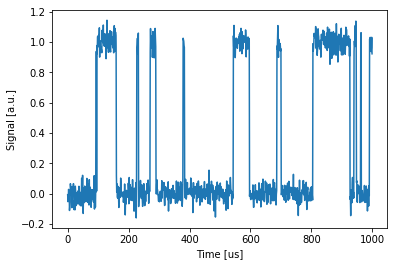

In [2]:
model_unit = 1e-6 # we work with microseconds as the baseunit
rate_up = 15e3 # kHz
rate_down = 25e3 # kHz
rts_model = ContinuousTimeMarkovModel(['zero', 'one'], [rate_up*model_unit,rate_down*model_unit], np.array([[0.,1],[1,0]]) )        
      
rts_data = generate_markov_chain_traces(rts_model, 1, 500000, initial_state = None, std_gaussian_noise=.05)
    
plt.figure(100); plt.clf()
plt.plot(rts_data.T[0:1000,:])
plt.xlabel('Time [us]')
_=plt.ylabel('Signal [a.u.]')

We analyse the signal to determine the tunnel rates and the separation between the two levels.

Fit parameters double gaussian:
 mean down: 0.000 counts, mean up:1.000 counts, std down: 0.050 counts, std up:0.050 counts
Separation between peaks gaussians: 10.016 std
Split between two levels: 0.500
Tunnel rate down: 15.0 kHz
Tunnel rate up: 25.1 kHz


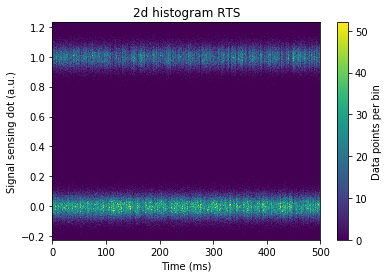

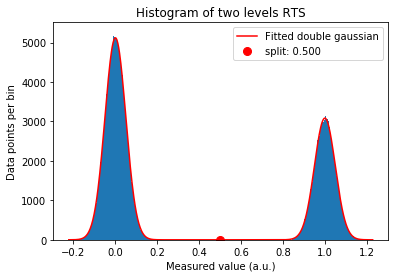

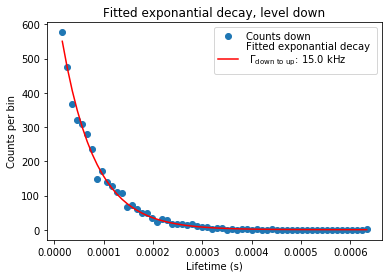

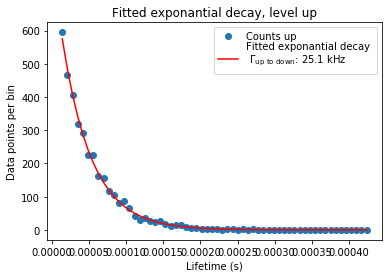

In [4]:
samplerate=1e6
tunnelrate_dn, tunnelrate_up, results = tunnelrates_RTS(rts_data.flatten(), samplerate=samplerate, min_sep = 1.0, max_sep=2222, min_duration = 10, fig=1, verbose=1)

### More efficient calculation of tunnel rates

The tunnel rates are calculated by fitting an exponential to a histogram of segment lengths.
The mean segment length contains roughly the same information and is perhaps more robust.

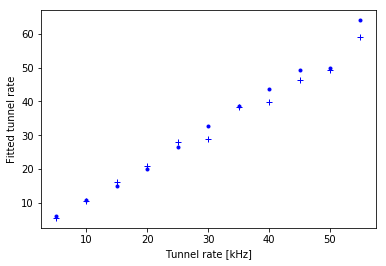

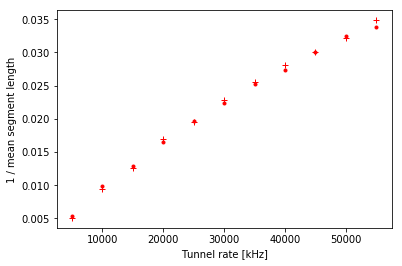

In [26]:
samplerate = 1e6

plt.figure(1000); plt.clf(); plt.xlabel('Tunnel rate [kHz]'); plt.ylabel('Fitted tunnel rate')
plt.figure(1001); plt.clf();  plt.xlabel('Tunnel rate [kHz]');  plt.ylabel('1 / mean segment length')
for jj, rate in enumerate(np.arange(5, 60, 5)*1e3):
    rate_up = rate
    rate_down = rate
    rts_model = ContinuousTimeMarkovModel(['down', 'up'], [rate_up*model_unit,rate_down*model_unit], np.array([[0.,1],[1,0]]) )        
        
    rtsdata = generate_markov_chain_traces(rts_model, 1, 155000, initial_state = None, std_gaussian_noise=.15)[0]
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        tunnelrate_dn, tunnelrate_up, results = tunnelrates_RTS(rtsdata, samplerate=samplerate, min_sep = 1.0, max_sep=2222, min_duration = 10, num_bins = 40, plungers=[], fig=0, verbose=0)

    plt.figure(1000)
    plt.plot(rate/1e3, tunnelrate_dn, '.b')
    plt.plot(rate/1e3, tunnelrate_up, '+b')
    plt.figure(1001)
    plt.plot(rate/1e3, 1./(samplerate*results['down_segments']['mean']), '.r')
    plt.plot(rate/1e3, 1./(samplerate*results['up_segments']['mean']), '+r')

Note that the variation in the mean segment length seems to be smaller that in the fitted exponentials.

## Elzerman readout

We model Elzerman readout with a Markov model with three states: empty, dot filled with a spin-up electron, dot filled with a spin-dot electron. The transitions possible are tunneling out of the system and decay of spin-up to spin-down (T1).

In [5]:
model_unit = 1e-6 # we work with microseconds as the baseunit

gamma_up_out = 10e3
gamma_down_out = .1e3
T1 = .2e-3
gamma_empty_down = 2e3

gamma_up_down = 1./T1 

G = np.array( [[-gamma_down_out, 0, gamma_down_out], [gamma_up_down, -(gamma_up_down+gamma_up_out), gamma_up_out], [gamma_empty_down, 0, -gamma_empty_down]] ).T
holding_parameters = -np.diag(G).reshape( (-1,1))
jump_chain= (1./holding_parameters.T)*G
jump_chain[np.diag_indices(G.shape[0])]=0 #-holding_parameters.flatten()

elzerman_model = ContinuousTimeMarkovModel(['spin-down', 'spin-up', 'empty'], holding_parameters*model_unit, jump_chain )
print(elzerman_model)

ContinuousTimeMarkovModel(id=0x178963f84e0, states=['spin-down', 'spin-up', 'empty'], generator=[[-1.0e-04  5.0e-03  2.0e-03]
 [ 0.0e+00 -1.5e-02  0.0e+00]
 [ 1.0e-04  1.0e-02 -2.0e-03]])


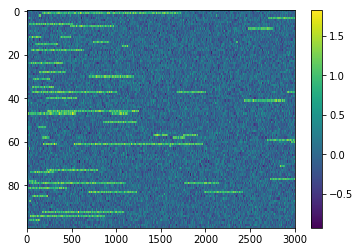

In [8]:
def generate_elzerman_sequences(elzerman_model, sensor_values={'spin-down': 0, 'spin-up':0, 'empty': 1}, std_gaussian_noise = 0.2,
                                number_of_samples=3000, number_of_traces=1000 ):
    initial_state=[.5, .5, 0]
    state_traces=elzerman_model.generate_sequences(number_of_samples, delta_time=1, initial_state=initial_state, number_of_sequences=number_of_traces)

    traces = state_traces.copy()
    for ii, key in enumerate(['spin-down', 'spin-up', 'empty']):
        traces[traces==ii]=sensor_values[key]
    # add noise
    if std_gaussian_noise != 0:
        traces = traces + np.random.normal(0, std_gaussian_noise, traces.size).reshape(traces.shape)

    initial_states=state_traces[:,0]
    return traces, state_traces, initial_states

traces, state_traces, initial_states = generate_elzerman_sequences(elzerman_model)

max_number_traces=100

plt.figure();
plt.imshow(traces[:max_number_traces,:])
plt.axis('tight')
_=plt.colorbar()

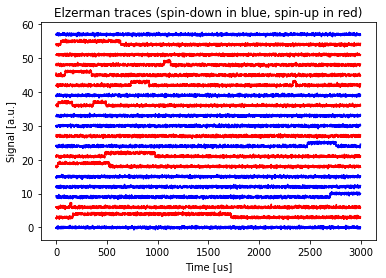

In [11]:
plt.figure();
for ii in range(20):
    offset=ii*3
    if initial_states[ii]==0:
        color='b'
    else:
        color='r'
    plt.plot(traces[ii]+offset, color=color)
plt.xlabel('Time [us]')
plt.ylabel('Signal [a.u.]')
_=plt.title('Elzerman traces (spin-down in blue, spin-up in red)')

In [16]:
def elzerman_threshold(traces, number_of_bins = 70):
    """ Determine threshold for Elzerman readout """
    counts, bins = np.histogram(traces.flatten(), bins=number_of_bins)
    bincentres = np.array([(bins[i] + bins[i + 1]) / 2 for i in range(0, len(bins) - 1)])
    par_fit, result_dict = fit_double_gaussian(bincentres, counts)

    result = {'readout_threshold': result_dict['split']}
    return result


def calculate_fidelity(traces, readout_threshold, readout_length):
    traces_smooth = scipy.ndimage.filters.convolve(traces, np.array([[1,1,1.]])/3, mode='nearest')      
    measured_states = np.max(traces_smooth[:, :readout_length], axis=1)>readout_threshold
    F= np.sum(initial_states==measured_states) /   measured_states.size 
    return F

elzermann_threshold_result = elzerman_threshold(traces)
readout_threshold=elzermann_threshold_result['readout_threshold']

F=calculate_fidelity(traces, readout_threshold, 3000)    
print('readout fidelity F %.2f' % F)

readout fidelity F 0.72


The optimal fidelity is a trade-off between longer measurement (so that a spin-up state can tunnel out) and shorter measurement (no accedental tunneling out of the ground state).

Text(0,0.5,'Fidelity')

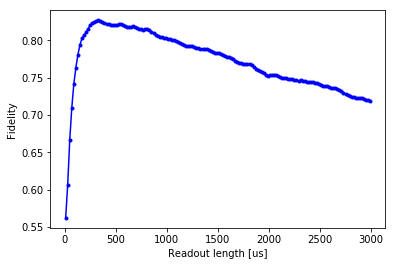

In [19]:
readout_lengths=np.arange(10, traces.shape[1], 20)
fidelities=np.zeros(readout_lengths.size)
for ii, readout_length in enumerate(readout_lengths):
    fidelities[ii]=calculate_fidelity(traces, readout_threshold, readout_length)    

fidelities=qtt.algorithms.generic.smoothImage(fidelities)
plt.figure(1000);
plt.clf()
plt.plot(readout_lengths, fidelities,'.-b', label='fidelity')
plt.xlabel('Readout length [us]')
_=plt.ylabel('Fidelity')